In [37]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import optax


import pickle as pkl

import itertools
import more_itertools as mit

import os

from alive_progress import alive_bar
import gc

import matplotlib.pyplot as plt

parallel_scan = jax.lax.associative_scan

In [38]:
def binary_operator_diag(element_i, element_j):
    a_i, bu_i = element_i
    a_j, bu_j = element_j

    return a_j * a_i, a_j * bu_i + bu_j


def init_lru_parameters(N, H, r_min = 0.0, r_max = 1, max_phase = 6.28):
    # N: state dimension, H: model dimension
    # Initialization of Lambda is complex valued distributed uniformly on ring
    # between r_min and r_max, with phase in [0, max_phase].

    u1 = np.random.uniform(size = (N,))
    u2 = np.random.uniform(size = (N,))

    nu_log = np.log(-0.5*np.log(u1*(r_max**2-r_min**2) + r_min**2))
    theta_log = np.log(max_phase*u2)

    # Glorot initialized Input/Output projection matrices
    B_re = np.random.normal(size=(N,H))/np.sqrt(2*H)
    B_im = np.random.normal(size=(N,H))/np.sqrt(2*H)
    C_re = np.random.normal(size=(H,N))/np.sqrt(N)
    C_im = np.random.normal(size=(H,N))/np.sqrt(N)
    D = np.random.normal(size=(H,))

    # Normalization
    diag_lambda = np.exp(-np.exp(nu_log) + 1j*np.exp(theta_log))
    gamma_log = np.log(np.sqrt(1-np.abs(diag_lambda)**2))

    return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log


def forward_LRU(lru_parameters, input_sequence):
    # Unpack the LRU parameters
    nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters

    # Initialize the hidden state
    Lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
    B_norm = (B_re + 1j*B_im) * jnp.expand_dims(jnp.exp(gamma_log), axis=-1)
    #print(B_norm.shape)
    C = C_re + 1j*C_im

    Lambda_elements = jnp.repeat(Lambda[None, ...], input_sequence.shape[0], axis=0)

    Bu_elements = jax.vmap(lambda u: B_norm @ u)(input_sequence)
    elements = (Lambda_elements, Bu_elements)
    _, inner_states = parallel_scan(binary_operator_diag, elements) # all x_k
    y = jax.vmap(lambda x, u: (C @ x).real + D * u)(inner_states, input_sequence)


    return y

In [39]:
def init_mlp_parameters(layers):
    # Initialize the MLP parameters
    parameters = []
    for i in range(len(layers)-1):
        W = np.random.normal(size=(layers[i], layers[i+1]))/np.sqrt(layers[i])
        b = np.zeros((layers[i+1],))
        parameters.append((W, b))

    return parameters

@jit
def forward_mlp(mlp_parameters, input, activation_function = jnp.tanh):
    # Forward pass of the MLP
    
    x = input

    for W, b in mlp_parameters:
        x = x @ W + b
        x = activation_function(x)

    return x

def forward_mlp_linear_with_classification(mlp_parameters, input, activation_function = jnp.tanh):
    
    x = input

    # Only apply the MLP up to the second last layer
    for W, b in mlp_parameters[:-1]:
        x = x @ W + b
        x = activation_function(x)

    # Apply the last layer without activation function
    W, b = mlp_parameters[-1]
    x = x @ W + b

    # Use the softmax function on the last layer
    x = jax.nn.softmax(x)


    return x

def layer_normalization(activations):
    mu  = jnp.mean(activations)
    sigma = jnp.std(activations)
    return (activations - mu) / sigma

layer_normalization_sequence = vmap(layer_normalization)

def max_pooling(sequence_to_pool):
    return jnp.max(sequence_to_pool, axis=0)

def mean_pooling(sequence_to_pool):
    return jnp.mean(sequence_to_pool, axis=0)

def sum_pooling(sequence_to_pool):
    return jnp.sum(sequence_to_pool, axis=0)

In [40]:
def model_forward(input_sequence, parameters):
    Linear_encoder_parameter,  LRU, seconday_parameters, Linear_decoder_parameter = parameters

    x = forward_mlp(Linear_encoder_parameter, input_sequence)
    skip = x
    x = layer_normalization_sequence(x)
    x = forward_LRU(LRU, x)
    x = forward_mlp(seconday_parameters, x) + skip
    x = max_pooling(x)
    x = forward_mlp_linear_with_classification(Linear_decoder_parameter, x)

    return x

# Batch model forward
batch_model_forward = vmap(model_forward, in_axes=(0, None))

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jit
def loss_fn(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)

    # Binary cross entropy loss
    return -jnp.mean(jnp.sum(target_sequences * jnp.log(y), axis=1))

@jit
def model_grad(input_sequence, target_sequence, parameters):
    return grad(loss_fn, argnums=2)(input_sequence, target_sequence, parameters)

@jit
def parameter_update(parameters, gradients, learning_rate = 0.01):
    new_parameters = []
    im = []
    for parameter, gradient in zip(parameters[0], gradients[0]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[1], gradients[1]):
        im.append(parameter - learning_rate * gradient)    

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[2], gradients[2]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[3], gradients[3]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    return new_parameters


@jit
def accuracy(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)
    return jnp.mean(jnp.argmax(y, axis=1) == jnp.argmax(target_sequences, axis=1))

batch_model_grad = vmap(model_grad, in_axes=(0, 0, None))

In [41]:
# Load model
with open('model_parameters.pkl', 'rb') as f:
    model_parameters = pkl.load(f)

In [42]:
# Hyperparameters
epochs = 5
batchsize = 1

In [43]:
# Load the test data
with open(f"datasets/8fmsk/waveforms_wrong_sync.pkl", "rb") as f:
    data = pkl.load(f)

data


[(Array([-0.14663146, -0.51548016, -0.14853974, ..., -0.80859274,
         -1.2138221 , -0.3857371 ], dtype=float32),
  0,
  1),
 (Array([ 0.0243161 ,  0.35375398, -0.360612  , ...,  1.8750998 ,
          1.8703758 , -0.12018712], dtype=float32),
  0,
  2),
 (Array([ 0.7974955,  0.8332967,  1.1115386, ..., -1.5914093, -1.3005717,
          0.7349541], dtype=float32),
  0,
  3),
 (Array([-0.82384086, -0.45060062, -0.93362904, ...,  0.6406777 ,
          1.8045512 , -0.7288939 ], dtype=float32),
  0,
  4),
 (Array([ 1.1051197 ,  0.8783493 ,  0.86639154, ..., -1.4310888 ,
          0.4966057 ,  1.2665831 ], dtype=float32),
  0,
  5),
 (Array([-0.6042226 , -0.38902044, -0.29707617, ..., -1.507831  ,
          2.0913038 , -0.7220952 ], dtype=float32),
  0,
  6),
 (Array([ 0.17124599, -0.22935395, -0.05492646, ..., -1.3099109 ,
          1.0017729 ,  0.36973727], dtype=float32),
  0,
  7),
 (Array([0.8356632 , 1.2018261 , 1.2292131 , ..., 1.4425874 , 0.87970614,
         1.190423  ], dtype=f

In [44]:
seqeunces = jnp.array([x[0]for x in data]).reshape(64,len(data[0][0]), 1)
seqeunces[0]

Array([[-0.14663146],
       [-0.51548016],
       [-0.14853974],
       ...,
       [-0.80859274],
       [-1.2138221 ],
       [-0.3857371 ]], dtype=float32)

In [45]:
model_parameters.keys()

dict_keys(['Untrained', 'Epoch 0', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Accuracy'])

In [46]:
#  Test the model with non-synced data


results = []

for i in range(64):
    results.append(model_forward(seqeunces[i], model_parameters["Epoch 719"]))

results

KeyError: 'Epoch 719'

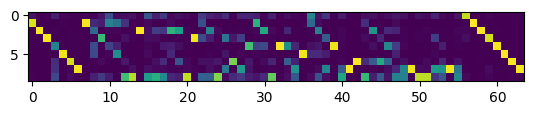

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(results).T, cmap='viridis')
plt.show()